# Evrişimli Sinir Ağları (Convolutional Neural Network)

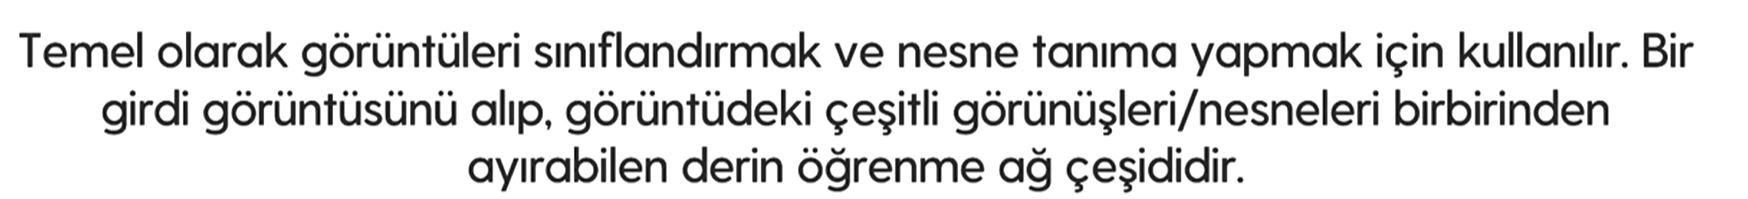

# Evrişimli Sinir Ağı Katmanları
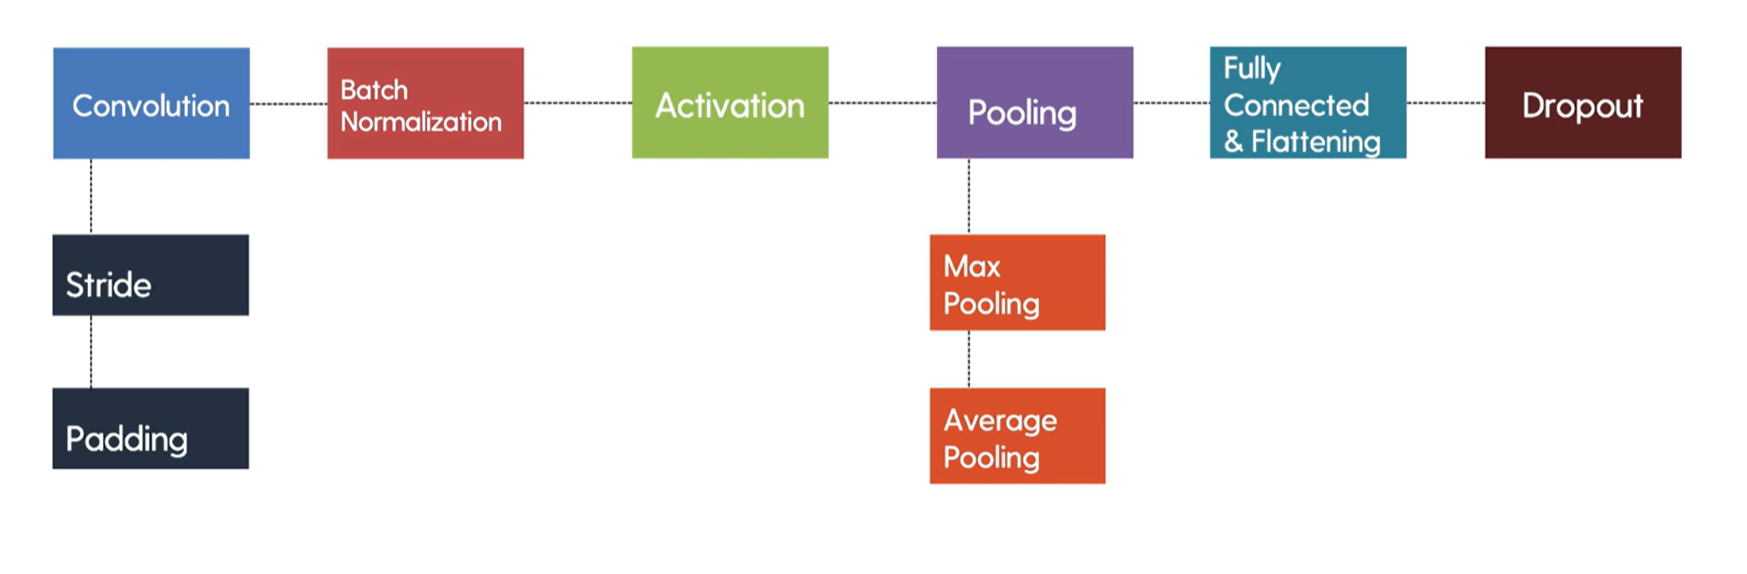

# Batch Normalization ve Aktivasyon Katmanı
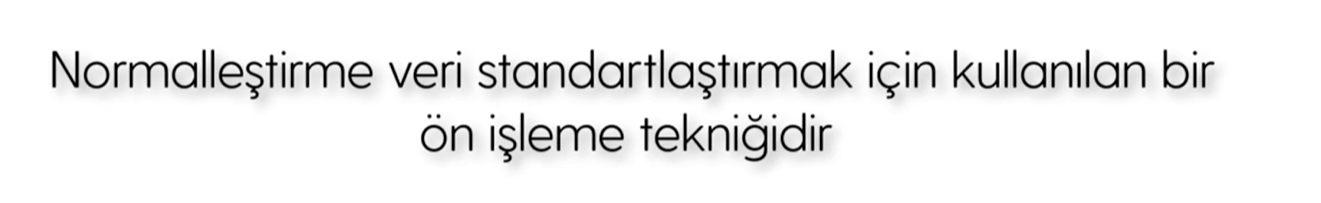
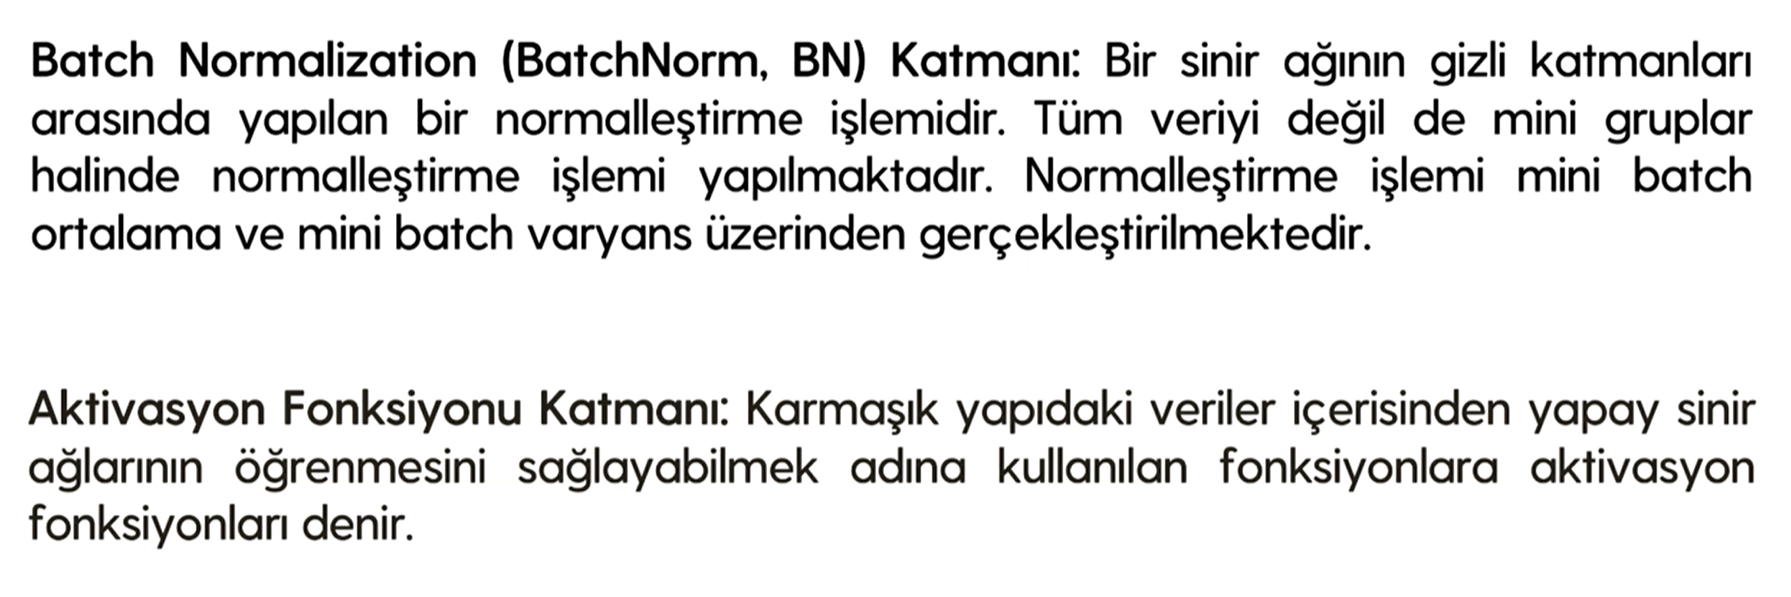

# Havuzlama (Pooling) Katmanı
* Görüntünün özelliklerini kaybetmeden boyutunun azaltılmasını sağlamaktadır.
* Bu katmanda herhangi bir öğrenme işlemi yapılmamaktadır.
* Evrişim Katmanından sonra kullanılan bir katmandır.
* Bu katmanı kullanma nedenimiz: Hesaplama karmaşıklığını azaltmak ve süreci hızlandırmak için kullanıyoruz.

### Average Pooling
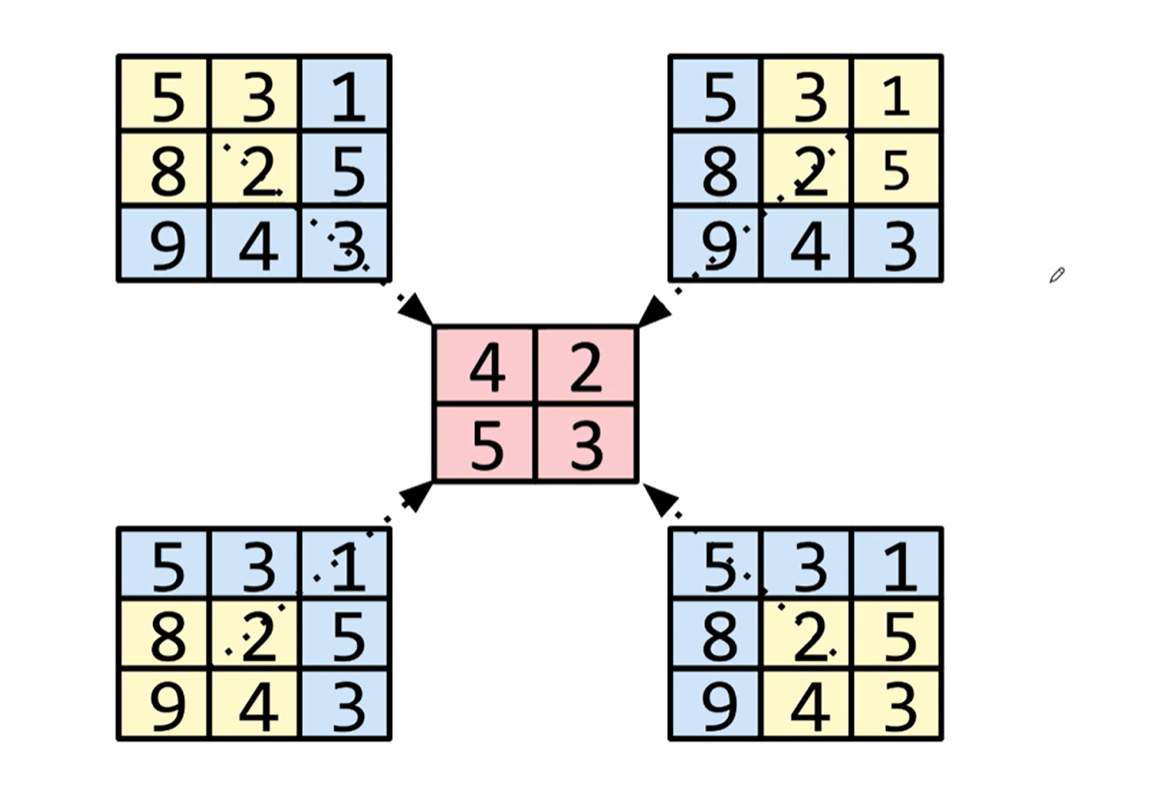

### Max Pooling
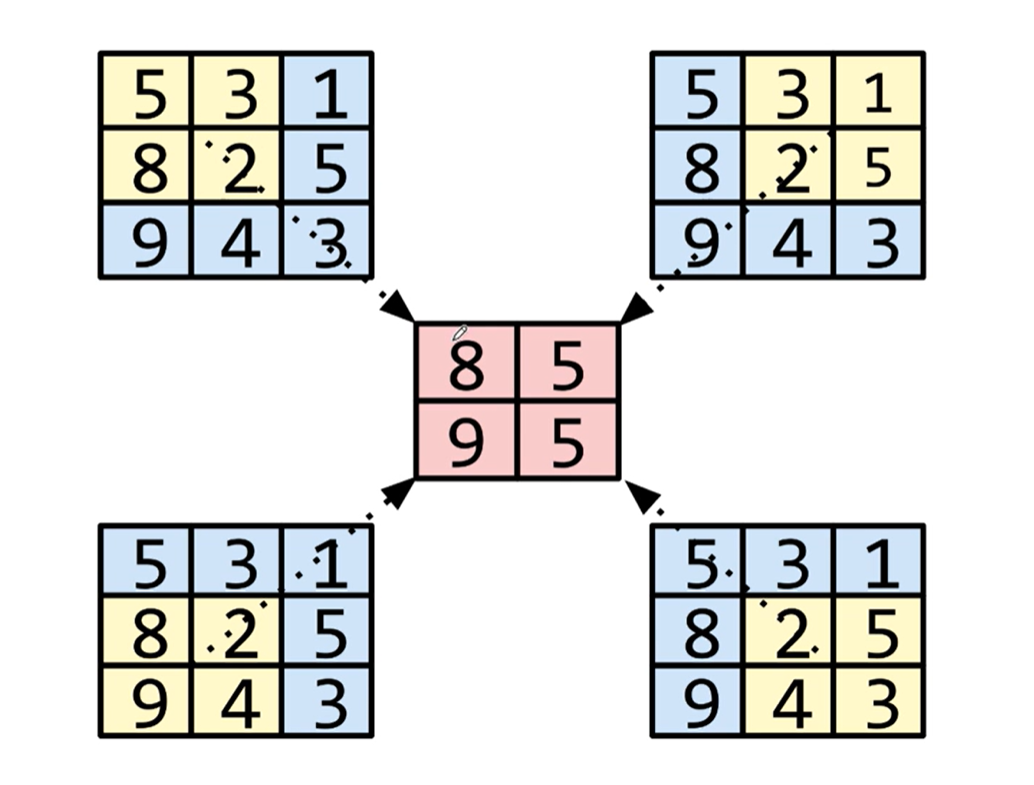

# Tam Bağlantı (Fully Connected & Flatten) Katmanı
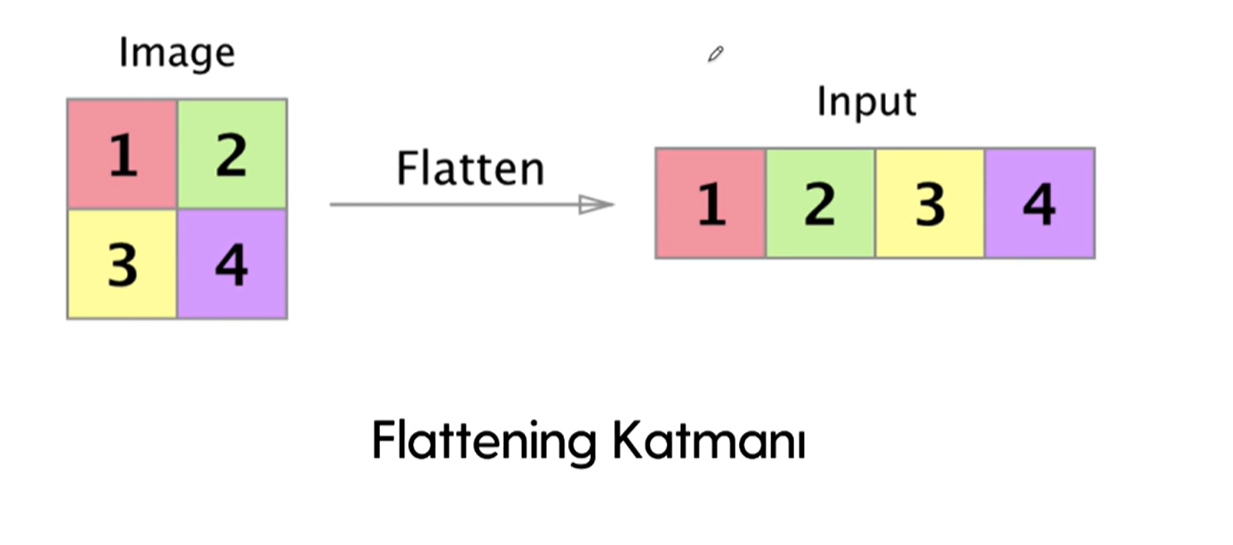
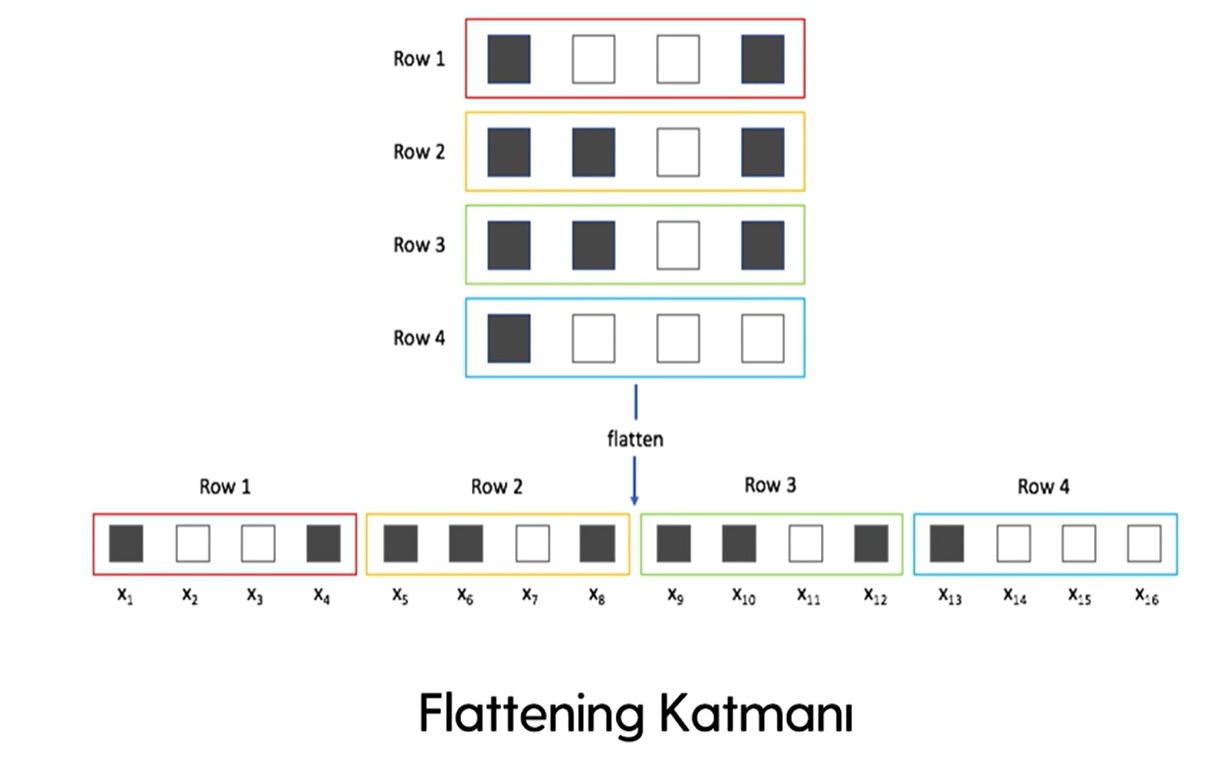
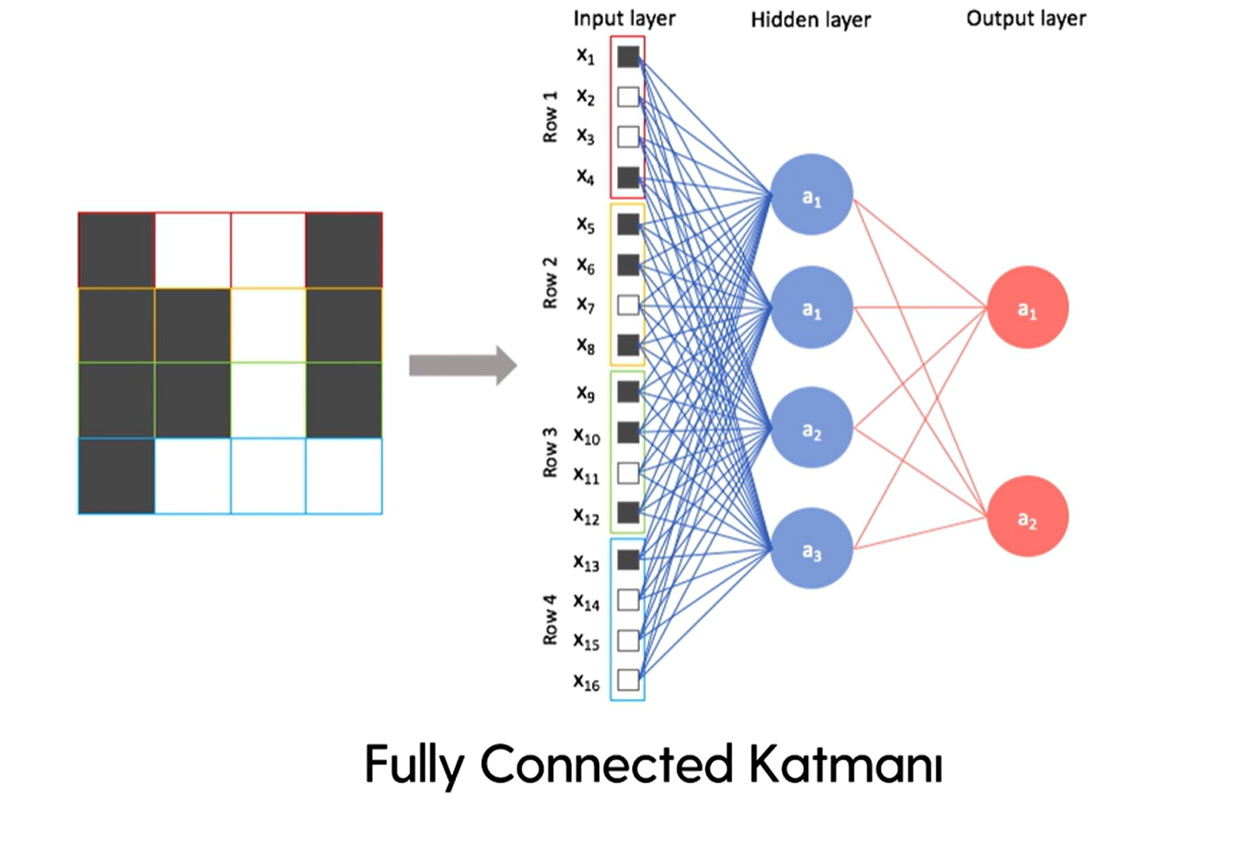
* Flatten Katmanı: Bize veri setinin matris formunu tek boyutlu diziye çevirme kısmında yardımcı olmaktadır.
* CNN'in modellemeye geçmeden önceki son katmanıdır

# Sönümleme (Dropout)
* Bu katman modelin aşırı öğrenme sorununu engelleyebilmek adına evrişimli sinir ağına ekleyebileceğimiz bir katmandır.

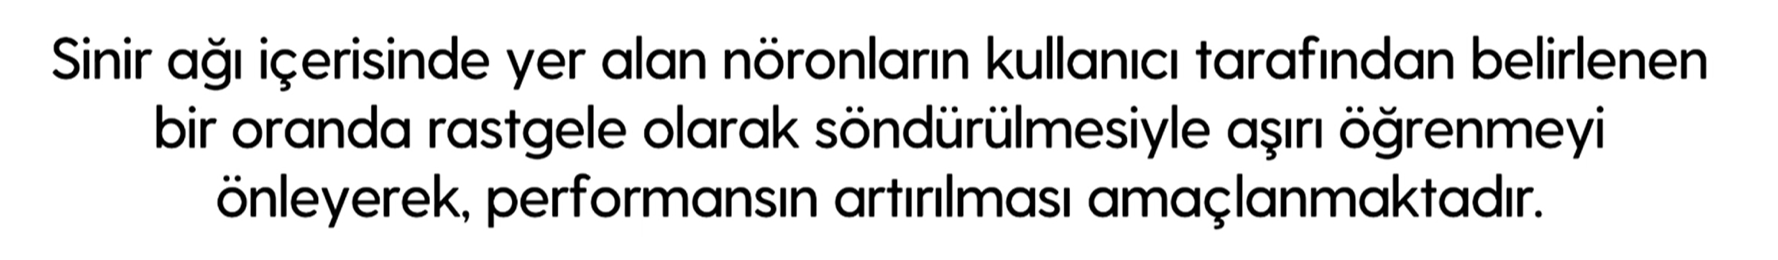

# CNN'in Mimari Yapısı

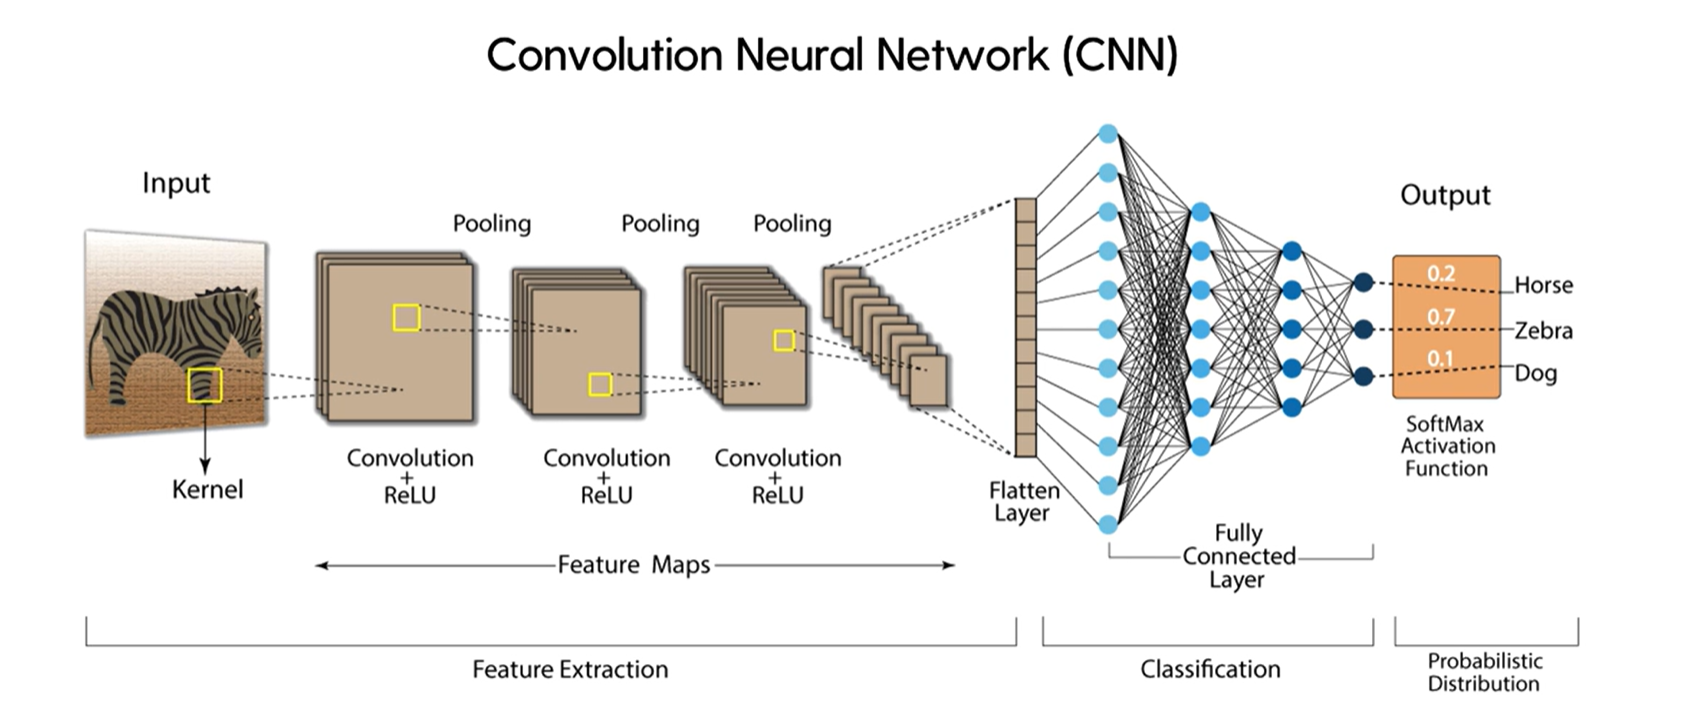

# **Evrişimli Sinir Ağı(CNN) Uygulama**

### Evrişimli Sinir Ağı(CNN) ile Katı Atık Tespiti

1) İş Problemi (Business Problem)
2) Veriyi Anlamak (Data Understanding)
3) Veriyi Hazırlamak (Data Prepatation)
4) Modelleme (Modeling) 
5) Değerlendirme (Evolation)

# 2) Veriyi Anlamak (Data Understanding)
#### **Veri Seti Hikayesi:** 
Bu proje kapsamında kullanıcağımız veri seti TrashNet isimli veri setidir. Stanford Üniversitesi öğrencileri tarafından hazırlanılmıştır. 
Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır. 
* Görüntüleri dağılımı:
* 501 Cam
* 594 Kağıt
* 401 Karton
* 482 Plastik
* 410 Metal
* 137 Çöp

* Fotoğraflar, nesne beyaz bir poster panosu üzerine yerleştirilerek ve güneş ışığı ve/veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler, 512x384 piksel boyutlarında ve 3 (RGB) kanallıdır.

In [1]:
!pip install imutils

In [2]:
# Veriyi Okuma ve işleme adımlarında kullanılacak kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

In [3]:
# Uyarı mesajlarını kapatmaya yaramaktadır.
from warnings import filterwarnings
filterwarnings("ignore")

In [32]:
# Model değerlendirme için kullanılacak kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [5]:
# Drive'da veri setinde yer alan görüntülerin olduğu path bilgisinin tutulması
dir_path = "Garbage Classification"

In [6]:
# Target size ve Label etiket değerlerinin belirlenmesi

target_size = (224, 224)

waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

In [7]:
def load_dataset(path):
  """
  Fonksiyonun Görevi: Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
  Parametreler:
  path: Görsellerin bulunduğu dizini ifade eder.
  Return: Döndürecek parametreler;
  x: Görüntülere ait matris bilgilerini tutar.
  labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
  """
  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_path = sorted(list(paths.list_images(path)))

  for image in image_path:
    # Belirtilen pathdeki görüntüler OpenCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image)
    # Okunan görüntüler başlangıçta belirtilen target_size'a göre yeniden ölçeklendirilir. Biz (224,224)'e çevirmekteyiz.
    img = cv2.resize(img, target_size)
    # Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    # Her bir path "/" ifadesi ile ayrıldığından listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image.split(os.path.sep)[-2]

    # Yakalan labelların sayısal değer karşılıklarının olduğu waste_label sözlüğü içerisinden gönderilen key değerine
    # karşılık value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

  # Veri seti random bir şekilde karıştırılır.
  x, labels = shuffle(x, labels, random_state=42)

  # Boyut ve sınıf bilgisi raporlanmaktadır.
  print(f"X Boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels

In [8]:
x, labels = load_dataset(dir_path)

X Boyutu: (2525, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2525


In [9]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


### Veri Setinden Örneklerin Gösterilmesi

In [10]:
def visualize_images(image_batch, label_batch):
  """
  Fonksiyonun Amacı: Veri seti içersinden görüntü görselleştirir.
  Parametreler:
  image_batch: Görüntülere ait matris bilgilerini tutar.
  label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.
  """

  plt.figure(figsize=(10, 10))
  for n in range(10):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    # One-hot encoded array'in 1 olan indeksini bulur, yani hangi sınıfa ait olduğunu belirler.
    label_index = np.argmax(to_categorical(label_batch, num_classes=6)[n])
    # Doğru sınıf adını alır.
    plt.title(list(waste_labels.keys())[label_index].title())
    plt.axis("off")

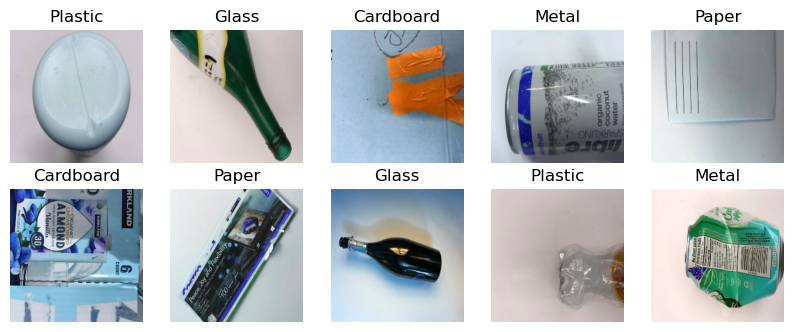

In [11]:
visualize_images(x, labels)

# 3) Veriyi Hazırlamak (Data Prepatation)

In [12]:
# Train veri seti için bir generator tanımlıyoruz

train = ImageDataGenerator(horizontal_flip = True,  # Görüntüleri yatay olarak rastgele çevirmektedir.
                           vertical_flip = True,    # Görüntüleri dikey olarak rastgele çevirmektedir.
                           validation_split = 0.1,  # Test setinin oranı anlamındadır.
                           rescale = 1./255,
                           # Yeniden ölçeklendirme faktörüdür. None veya 0 ise yeniden ölçeklendirme uygulanmaz. Resimler 0-1 arası ölçekler.
                           shear_range = 0.1,       # Görüntünün şekline eğim vermek için kullanılır.
                           zoom_range = 0.1,
                           width_shift_range = 0.1, # Genişlik kaydırma işlemi gerçekleştirmektedir.
                           height_shift_range = 0.1) # Yükseklik kaydırma işlemi gerçekleştirmektedir.

# Test veri seti için generator tanımlıyoruz
test = ImageDataGenerator(rescale = 1./255,
                          validation_split = 0.1)

In [13]:
train_generator = train.flow_from_directory(directory = dir_path,
                                            target_size = target_size,
                                            class_mode = "categorical",
                                            subset = "training")

test_generator = test.flow_from_directory(directory = dir_path,
                                          target_size = target_size,
                                          batch_size = 251,
                                          class_mode = "categorical",
                                          subset = "validation")

Found 2274 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4) Modelleme (Modeling)

### 4.1) Sıfırdan CNN Modeli Kurma
* Sequantial
* Evrişim Katmanı (Convolution Layer, Conv2D)
* Havuzlama Katmanı (Pooling Layer)
* Aktivasyon Fonksiyonu Katmanı (Activation Function Layer)
* Flattening Katmanı
* Dense Katmanı
* Dropout Katmanı

In [14]:
model = Sequential()  # Sequantial kelimesi sıralı anlamına gelmektedir.

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same" ,activation = "relu", input_shape = input_shape))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same" ,activation = "relu"))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same" ,activation = "relu"))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))
model.add(Dropout(rate = 0.2))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dropout(rate = 0.2))

# Son katmanımız burada unit'in 6 olma nedeni 6 sınıfımızın olmasından kaynaklıdır.
model.add(Dense(units = 6, activation = "softmax"))

* Yukarıdaki tanımlanan model kodu bizim evrişimli katmanı tanımlamamızı temsil etmektedir.
* "filters = 32" bir görüntü üzerinde gezdirelecek olan filtre sayısını temsil eder.
* "kernel_size = (3, 3)" ifadesi gezdirelecek olan filtrenin boyut bilgisi anlamına gelmektedir.
* "padding = "same" " ifadesi çıkış matrisi ile giriş matrisinin aynı genişlik ve yükseklik boyutuna sahip olacak şekilde girdinin soluna, sağına, yukarı veya aşağısına eşit olarak 0 pixel değerleri yerleştirilecektir anlamına gelmektedir.
* "input_shape = input_shape" ifadesi giriş görüntülerinin boyut bilgisini temsil etmektedir.
* "activation = "relu" " ifadesi aktivasyon fonksiyonumuzu ifade etmektedir. Yani filtreleme işlemi yapıldıktan sonra diğer katmana geçiş için aktivasyon fonksiyonu olarak "relu" fonksiyonu kullanılacaktır.
* Pooling ise havuzlama olarak düşünülebilir. En temelinde görüntünün özelliklerini kaybetmeden boyutunun azaltılması işlemidir.
* "MaxPooling2D" Evrişim işleminden sonra oluşan çıktı matrisi üzerinde filtrenin gezmiş olduğu noktaların maksimum değerleri alınarak çıkış matrisi oluşturulmaktadır.
* "pool_size = 2" Pooling işlemine görüntü üzerinde gezdirilecek olan filtrenin boyut bilgisini ifade etmektedir.
* Pooling işleminin kullanılma amacı evrişimli katmandan sonra oluşacak performans probleminin önüne geçmek için kullanılır.
* Flatten Katmanı: Convolution ve pooling katmanlarından gelen matrislerin tek boyutlu diziye çevrilmesi işlemini gerçekleştirmektedir. Yani yapay sinir ağının girişlerine uygun hâle getirme görevini görmektedir.
* Dense Katmanı: Katmanlar arasında nöron ya da düğümlerin geçişlerini sağlamaktadır. Yani bir katmandan aldığı nöronların bir sonraki katmana girdi olarak bağlanmasını sağlar.
* Dropout Katmanı: Aşırı öğrenmenin önüne geçmek için yani overfittingi engellemek için kullanılan bir argümandır. Sinir ağındaki nöronların kullanıcı tarafından belirlenen bir oranda rastgele söndürülmesiyle aşırı öğrenmeyi engellemektedir.

### 4.2) Model Özeti

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

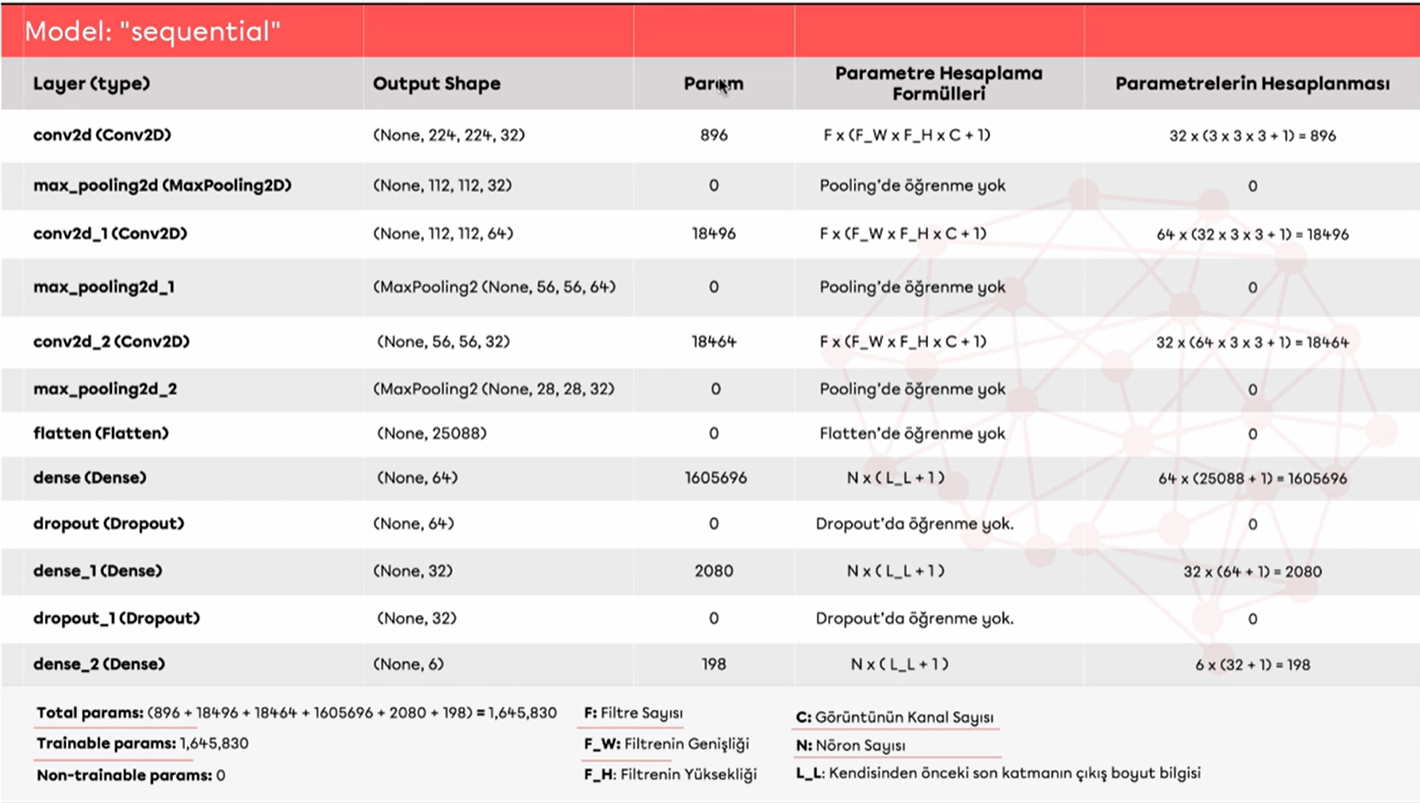

### 4.3) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [16]:
model.compile(loss = "categorical_crossentropy",  # İkiden fazla sınıfa sahip olduğumuz için bunu kullanmaktayız.
              # İkili sınıf olsaydı eğer "binary_crossentropy" kullanılırdı.
              optimizer = "adam",
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [18]:
callbacks = [EarlyStopping(monitor = "vall_loss", patience = 50, verbose = 1, mode = "min"),
             ModelCheckpoint(filepath = "Mymodel.keras", monitor = "val_loss", mode = "min", save_best_only = True, save_weights_only = False, verbose = 1)]

* "callbacks" Sinir ağını eğitirken iterasyonları ve gerektiğinde EarlyStopping kontrolünü yapmak, iterasyonları kaydetmek, model bilgilerini kaydetmek adına callbacks adında bir liste oluşturduk.
* "EarlyStopping" model veriyi ezberlemeye başladığında durmamıza yardımcı olur.
* "monitor" modelin gelişimini aşırı öğrenmeyi engellemek adına hangi metrik açısından takip edicez sorusunun yanıtıdır. Yukarıda ise bu sorunun cevabını validasyon lossuna göre ayarladık.
* "patience" ise nerede duracağını belirtir. Yani 50 adım sonucunda ilerleme olmazsa duracaktır. Epoch ile aynıdır.
* "verbose" 0 olursa çıktı vermez. 1 olursa progressbar olup onu gösterir. 2 olursa da her bir epoch sonucunu açık açık gösterir.
* "mode" model gelişimini takip edileceği parametre değerlerini -min,max,otomatic- kullanır.
* min: İzlenen miktarın azalması durduğunda eğitim durur.
* max: İzlenen miktarın artması durduğunda eğitim durur.
* otomatic: Gidilecek yön izlenen miktarın ardından otomatik olarak çıkarılır.
* "ModelCheckpoint" kısmında modelin iterasyonları devam ederken yakalanacak olan en iyi modelin kaydedilmesi işlemini bu fonksiyonu kullanarak gerçekleştiririz. Kısaca modeli izlemek için kullanılan bir özelliktir.
* "save_best_only" ile sadece en iyi modeli kaydeti True yaptık ki en iyi modeli kaydedebilsin.


### 4.4) Modelin Eğitilmesi

In [24]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks,
    steps_per_epoch=2276 // 32,
    validation_steps=251 // 32)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - acc: 0.6317 - loss: 0.9443 - precision: 0.7850 - recall: 0.4997
Epoch 1: val_loss improved from 1.06101 to 1.00775, saving model to Mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 421ms/step - acc: 0.6319 - loss: 0.9441 - precision: 0.7851 - recall: 0.4998 - val_acc: 0.6255 - val_loss: 1.0077 - val_precision: 0.7898 - val_recall: 0.4940
Epoch 2/100
 1/71 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - acc: 0.6250 - loss: 0.8862 - precision: 0.7200 - recall: 0.5625
Epoch 2: val_loss did not improve from 1.00775
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.6250 - loss: 0.8862 - precision: 0.7200 - recall: 0.5625 - val_acc: 0.6295 - val_loss: 1.0102 - val_precision: 0.8000 - val_recall: 0.4940
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - acc: 0.6655 - loss: 0.8877 - precision: 0.7873 - recall: 0.5263
Epoch 3: val_loss improved from 1.00775 to 1.00481, saving model to Mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 410ms/step - acc: 0.66

### 4.5) Accuracy ve Loss Grafikleri

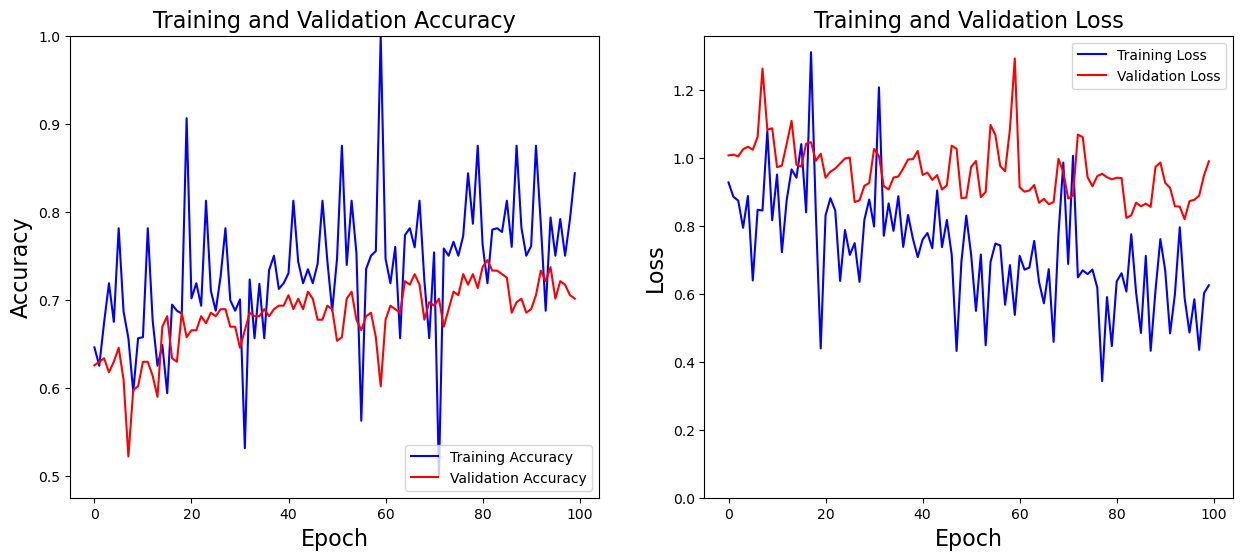

In [25]:
#-----------------
# Accuracy Grafiği
#-----------------
plt.figure(figsize = (15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], color = "blue", label = "Training Accuracy")
plt.plot(history.history["val_acc"], color = "red", label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy", fontsize = 16)

#--------------
# Loss Grafiği
#--------------
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color = "blue", label = "Training Loss")
plt.plot(history.history["val_loss"], color = "red", label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize = 16)
plt.show()

# 5) Değerlendirme (Evolation)

In [26]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size = 32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.7012 - loss: 0.9903 - precision: 0.8103 - recall: 0.6295


In [27]:
print("Test Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Percision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))

Test Accuracy: 70.1%

Test Loss: 99.0%

Test Percision: 81.0%

Test Recall: 62.9%


In [29]:
# Classification Report 
x_test, y_test = test_generator.__next__()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis = 1)

y_test = np.argmax(y_test, axis = 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [33]:
target_names = list(waste_labels.keys())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.79      0.57      0.67        40
       glass       0.75      0.82      0.78        50
       metal       0.58      0.76      0.66        41
       paper       0.68      1.00      0.81        59
     plastic       0.84      0.33      0.48        48
       trash       0.75      0.46      0.57        13

    accuracy                           0.70       251
   macro avg       0.73      0.66      0.66       251
weighted avg       0.73      0.70      0.68       251



In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, 
                         normalize = False,
                         title = "Confuison Matrix", 
                         cmap = plt.cm.Blues):
    if normalize: 
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]

    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontweight="bold")
    plt.xlabel('Predicted label', fontweight="bold")

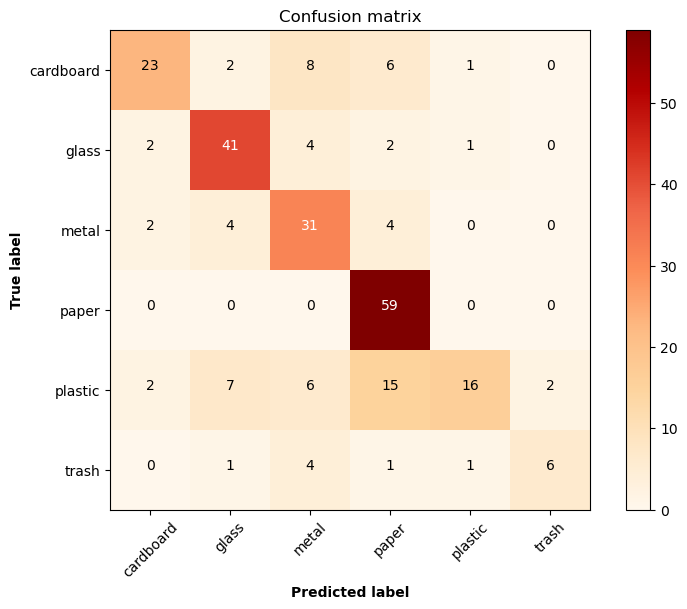

In [40]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)

# Modelin Kullanılması / Test Edilmesi

In [55]:
waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


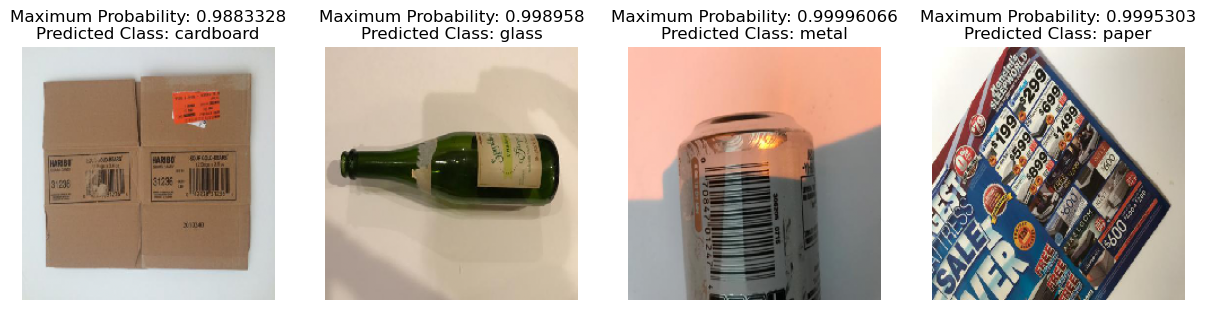

In [56]:
def model_testing(path):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])

    return img, p, predicted_class

# Test edilen görsellerin listesi
img1, p1, predicted_class1 = model_testing("cardboard130.jpg")
img2, p2, predicted_class2 = model_testing("glass37.jpg")
img3, p3, predicted_class3 = model_testing("metal34.jpg")
img4, p4, predicted_class4 = model_testing("paper42.jpg")

# Model testini yapalım
plt.figure(figsize=(15, 6))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1.squeeze())
# predicted_class1'i kullanarak, waste_labels'a göre sınıf ismini bulma
predicted_class_name1 = [k for k, v in waste_labels.items() if v == predicted_class1][0]
plt.title("Maximum Probability: " + str(np.max(p1[0])) + "\n" + "Predicted Class: " + predicted_class_name1)
plt.imshow(img1)

plt.subplot(142)
plt.axis("off")
plt.imshow(img2.squeeze())
predicted_class_name2 = [k for k, v in waste_labels.items() if v == predicted_class2][0]
plt.title("Maximum Probability: " + str(np.max(p2[0])) + "\n" + "Predicted Class: " + predicted_class_name2)
plt.imshow(img2)

plt.subplot(143)
plt.axis("off")
plt.imshow(img3.squeeze())
predicted_class_name3 = [k for k, v in waste_labels.items() if v == predicted_class3][0]
plt.title("Maximum Probability: " + str(np.max(p3[0])) + "\n" + "Predicted Class: " + predicted_class_name3)
plt.imshow(img3)

plt.subplot(144)
plt.axis("off")
plt.imshow(img4.squeeze())
predicted_class_name4 = [k for k, v in waste_labels.items() if v == predicted_class4][0]
plt.title("Maximum Probability: " + str(np.max(p4[0])) + "\n" + "Predicted Class: " + predicted_class_name4)
plt.imshow(img4)


# DONE